<a href="https://colab.research.google.com/github/AnanyaJain3/Occluded_Facial_Realtime_Detection/blob/main/python%20files/Custom_Model_BackBone_GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import concatenate

import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


importing our data , path is local storage folder

In [ ]:
shape_x = 48
shape_y = 48

In [6]:
X_train = X_train.reshape(75000,shape_x,shape_y,1)
X_test = X_test.reshape(25000,shape_x,shape_y,1)

NameError: name 'path' is not defined

creating an inception block

In [15]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4):
  # Input:
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer


custom model using inception block

In [16]:
def ANYnet():
  # input layer
  input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(5, activation = 'softmax')(X1)


  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1000, activation = 'softmax')(X2)


  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32,
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer
  X = Dropout(0.4)(X)

  # output layer
  X = Dense(1000, activation = 'softmax')(X)

  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [17]:
custom_model = ANYnet()


In [18]:
custom_model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 109, 109, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 54, 54, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 54, 54, 64)           4160      ['max_pooling2d[0][0]'

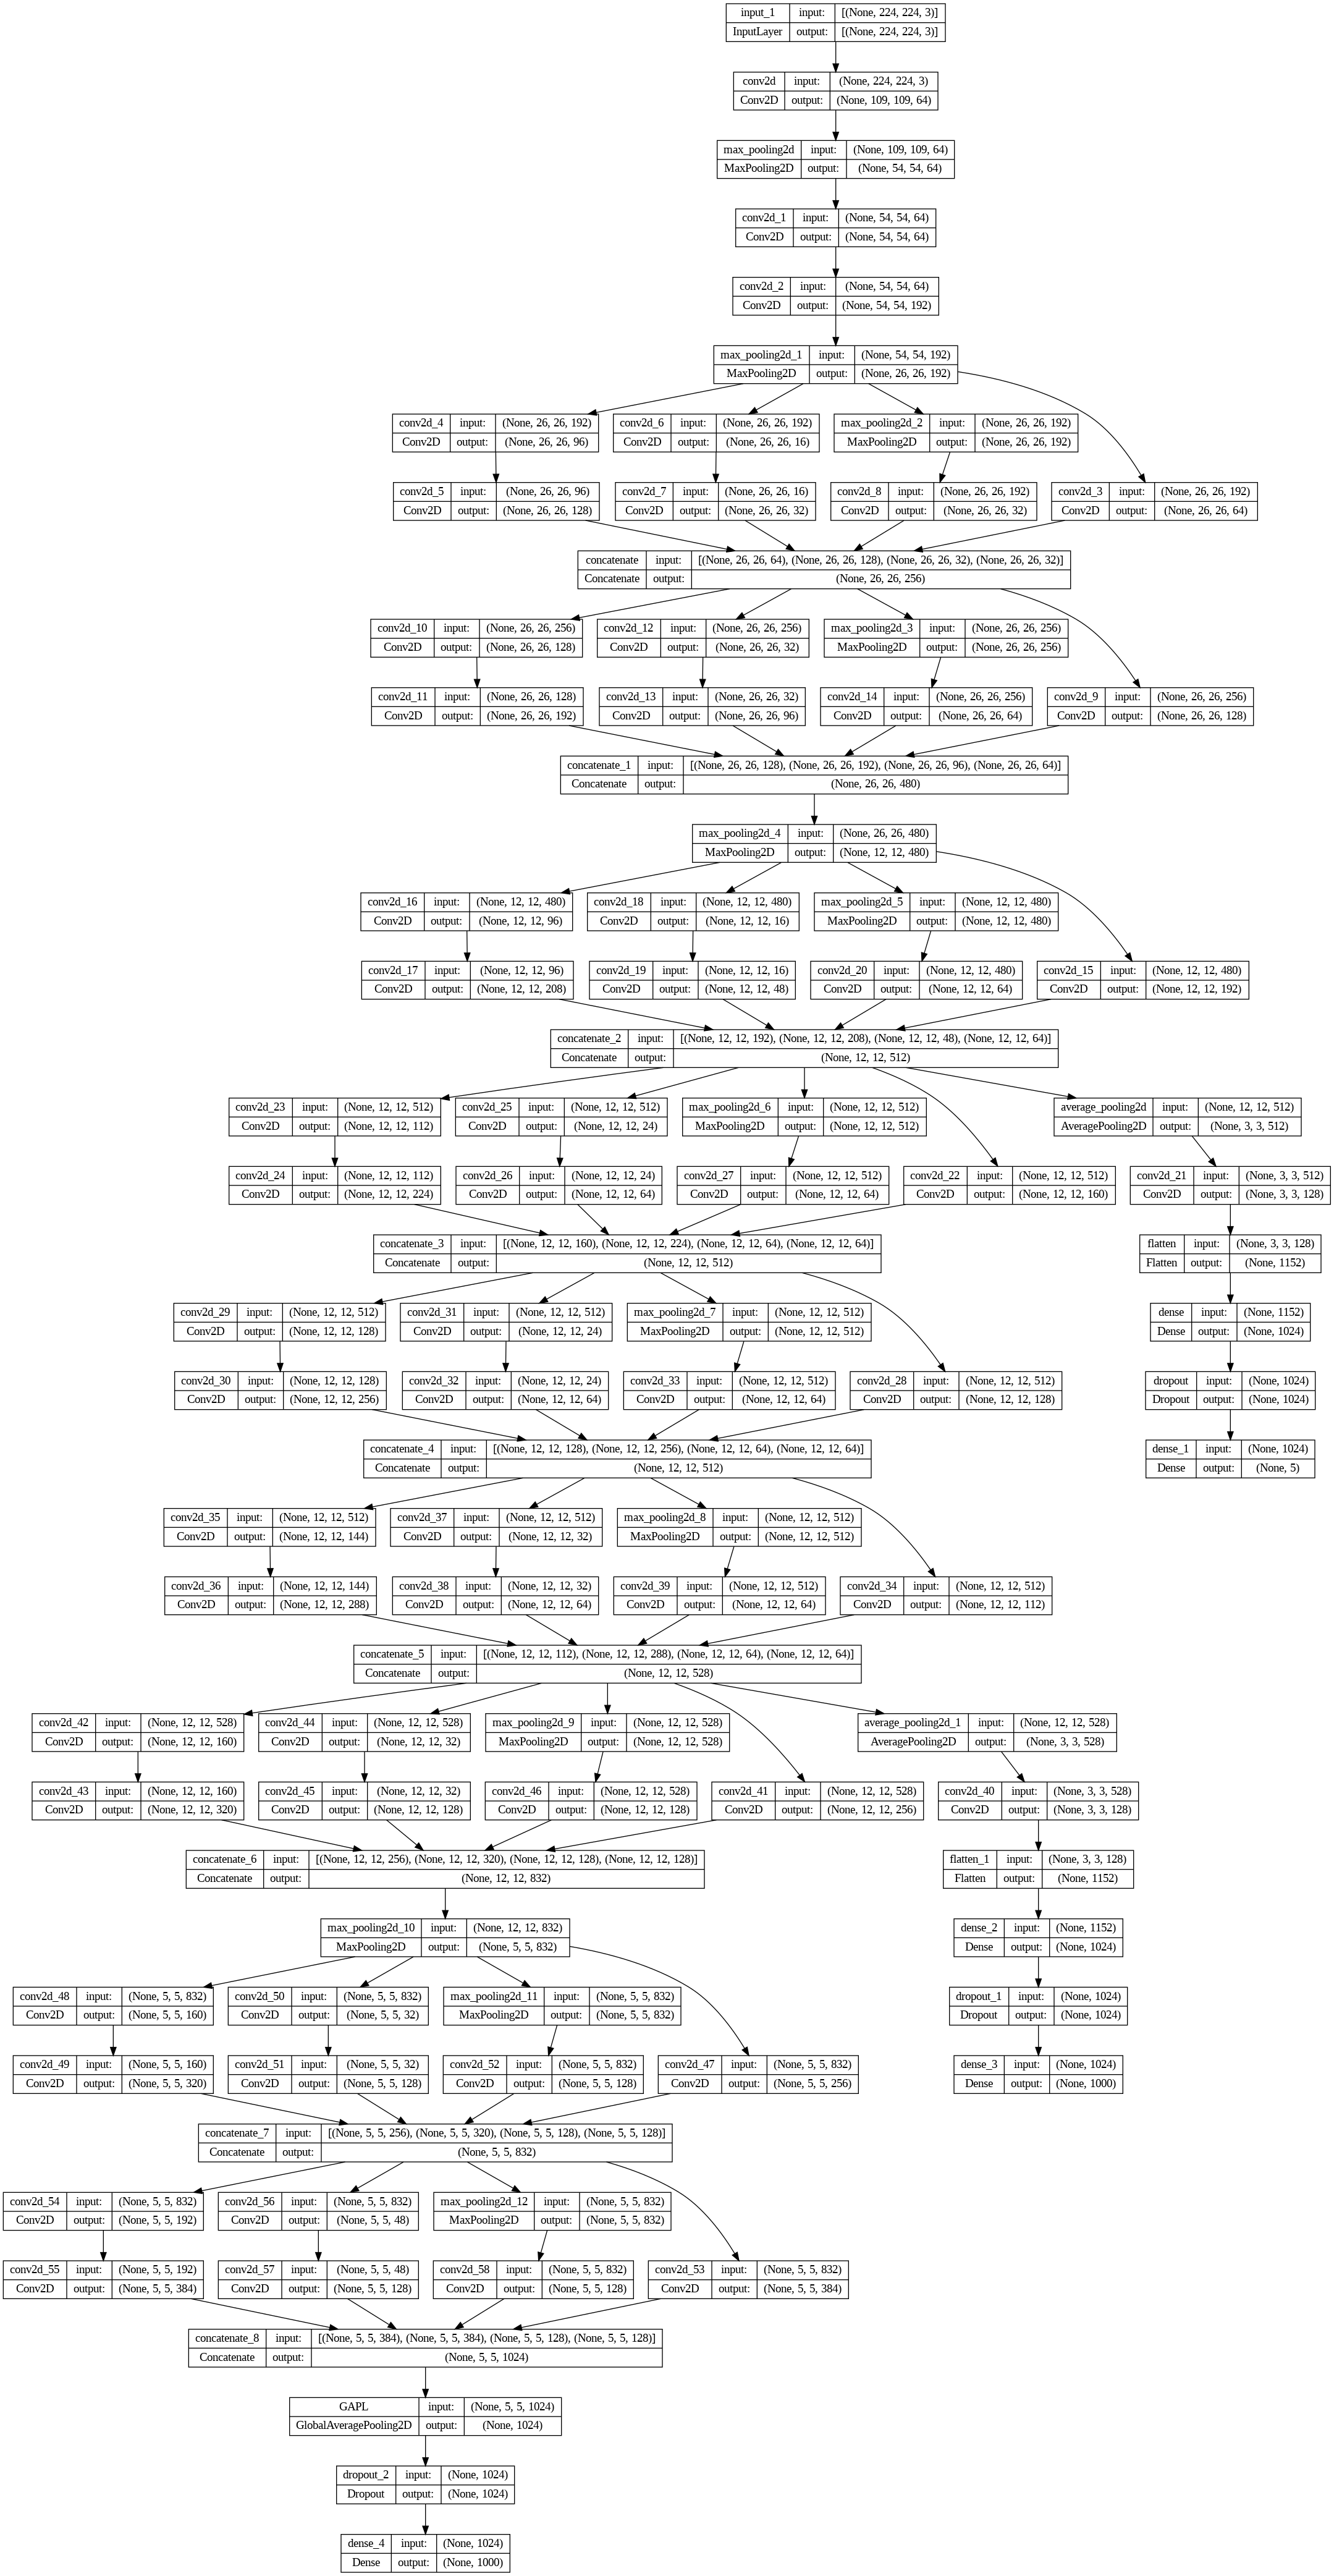

In [19]:
# Assuming you have an input layer, e.g., input_layer = Input(shape=(224, 224, 3))
input_layer = Input(shape=(224, 224, 3))

# Plot the model
plot_model(custom_model, to_file='ANYnet_plot.png', show_shapes=True, show_layer_names=True)




running the model

We have discovered the architecture as well as the implementation of the GoogLeNet model on the Keras platform. It is composed of Inception blocks. Each block has a special architecture where it extracts simultaneously the input features through four parallel paths. Besides, the 1×1 convolutional layers are maximum applied in these paths to reduce channel dimensionality. Moreover, the application of the max-pooling layer between some Inception blocks plays a role in reducing the resolution, thus reducing the computational complexity. In summary, the parameter number of this model is 6x smaller than the Alexnet model and much smaller than the VGG model. Especially, it outperforms these models. This interesting architecture of GoogLeNet is also an inspiration for the appearance of later models.

In [20]:
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 512
epochs = 1

In [22]:
history = custom_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

NameError: name 'X_train' is not defined